In [80]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nitashakochar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
import nltk
from nltk import FreqDist
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy used for lemmatization
import spacy

# Tools for plotting topic model
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# FreqDist visualization
import seaborn as sns

In [82]:
import pandas as pd
with open('2sample_50000_2.json', 'r') as json_file: 
        df = pd.read_json(json_file, lines = False)
df.head()


,index,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,4333274,IWN2heYitkg-D4UdqfxcMA,0,2015-10-29 12:53:11,0,0maSioOL3q-LcZz_rqVeXw,5,"Wow, we LOVED this place! We went on a Sunday ...",0,4ndo0S-dn8t_aKZxTW5KsQ
1,2582902,rcaPajgKOJC2vo_l3xa42A,0,2015-08-06 05:11:04,0,YNWxYHQscRZuh5BWArk4xA,5,Let's start with dessert... Four diners chose ...,0,D86zT4klAF6Em3UpljEBaA
10,1567053,JpgVl3d20CMRNjf1DVnzGA,1,2014-08-31 01:51:22,1,fcpzuj26HdrqUdUHv10cHg,3,If you've been to a nice churrascaria before t...,4,sEtPEkIFi5UdBx-GCWPAgA
100,753034,iCQpiavjjPzJ5_3gPD5Ebg,0,2014-07-15 01:40:31,0,HibiYgdElligW6XXLxxvog,5,Amazing doesn't even begin to describe this pi...,0,SqeBzCpSehkkI_UbrMmktw
1000,6204300,2weQS-RnoOBhb1KsHKyoSQ,0,2016-02-15 18:42:18,2,V6fWULsIRsu7hAIlbj8n1g,2,This was a ehhh buffet in my opinion. Well ove...,2,Nnki4lJhXJ2H1ew_wTrlmQ


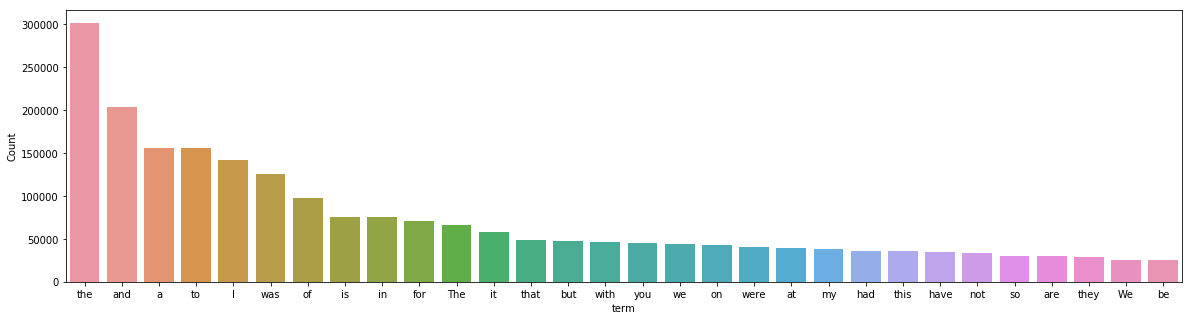

In [83]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_the_words = ' '.join([text for text in x])
    all_the_words = all_the_words.split()
    fdist = FreqDist(all_the_words)
    words_df = pd.DataFrame({'term':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    dt = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=dt, x= "term", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    

freq_words(df['text'])

# freq function adopted from https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

In [84]:
# Convert to list
data = df.text.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]


print(data[1:2])

["Let's start with dessert... Four diners chose four desserts.... Figs n Berries with Thyme ice cream , Creme BrÃ»lÃ©e , lemon tart with pinion crust, and something with chocolate sauce!!! No fault with this sweet array of perfection! Was surprised waiter made no after dinner beverage recommendations. Waiter was friendly and staff attentive! Refills were abundant, first rate attention to every detail! While the choice of swordfish was mine... It was the trout that stole the show where fish was concerned! It's so delightful to dine with foodies who live to share bites! Chicken was succulent also putting my dry swordfish to shame. It was a shame I didn't eat more of the laurel bread n butter... Sweet cream butter... Laid out directly on the tablecloth...interesting... And why Not???now let's talk Lamb! Moist, tender rich in flavor...four nice medallions made mouths water. The contents of that plate evaporated swiftly! Sooo yummy! Beer list is nice, waitstaff is knowledgeable on pairings 

In [85]:
# Tokenize words and clean-up text
# deacc=True removes punctuations

def tokenize_reviews(reviews):
    for review in reviews:
        yield(gensim.utils.simple_preprocess(str(review), deacc=True))

word_data = list(tokenize_reviews(data))

print(word_data[1:2])


[['let', 'start', 'with', 'dessert', 'four', 'diners', 'chose', 'four', 'desserts', 'figs', 'berries', 'with', 'thyme', 'ice', 'cream', 'creme', 'bra', 'la', 'lemon', 'tart', 'with', 'pinion', 'crust', 'and', 'something', 'with', 'chocolate', 'sauce', 'no', 'fault', 'with', 'this', 'sweet', 'array', 'of', 'perfection', 'was', 'surprised', 'waiter', 'made', 'no', 'after', 'dinner', 'beverage', 'recommendations', 'waiter', 'was', 'friendly', 'and', 'staff', 'attentive', 'refills', 'were', 'abundant', 'first', 'rate', 'attention', 'to', 'every', 'detail', 'while', 'the', 'choice', 'of', 'swordfish', 'was', 'mine', 'it', 'was', 'the', 'trout', 'that', 'stole', 'the', 'show', 'where', 'fish', 'was', 'concerned', 'it', 'so', 'delightful', 'to', 'dine', 'with', 'foodies', 'who', 'live', 'to', 'share', 'bites', 'chicken', 'was', 'succulent', 'also', 'putting', 'my', 'dry', 'swordfish', 'to', 'shame', 'it', 'was', 'shame', 'didn', 'eat', 'more', 'of', 'the', 'laurel', 'bread', 'butter', 'sweet'

In [86]:
# Creating bigram and trigram models
bigram = gensim.models.Phrases(word_data, min_count=5, threshold=100)
bigram_model = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[word_data], threshold=100)  
trigram_model = gensim.models.phrases.Phraser(trigram)



In [87]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
BuckleySaltonSWL = open("stopwords copy.txt").read().splitlines()
stop_words.extend([w.lower() for w in BuckleySaltonSWL])

In [88]:
# Simple preprocess comes from Gensim library found here: 
# https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html
    
nlp = spacy.load('en', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def create_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

def create_trigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sentence in texts:
        doc = nlp(" ".join(sentence)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token) > 3])
    return texts_out

In [89]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Create bigrams
data_bigrams = create_bigrams(data_words_nostops)

# Create trigrams
data_trigrams = create_trigrams(data_bigrams)

data_lemmatized = lemmatization(data_trigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])


[['brunch', 'decor', 'white', 'restaurant', 'patio', 'lot', 'sunlight', 'attentive', 'snob', 'salad', 'protein', 'omelette', 'tasty', 'sugar', 'coma', 'bowl', 'fruit', 'dish', 'snack', 'restaurant']]


In [90]:
# make each array into a string
list_of_strings=[]
for row in data_lemmatized:
    string = " ".join(row)
    list_of_strings.append(string)

list_of_strings

# make all words into 1 large string
big_string=''
for row in data_lemmatized:
    string = " ".join(row)
    big_string = big_string + string

In [91]:
import nltk
tokens = nltk.word_tokenize(big_string)

fdist = FreqDist(tokens)

In [92]:
fdist.most_common(20)

[('room', 27563),
 ('food', 23668),
 ('hotel', 15915),
 ('vegas', 10301),
 ('restaurant', 9563),
 ('night', 9151),
 ('buffet', 8841),
 ('burger', 8388),
 ('line', 8099),
 ('strip', 7640),
 ('casino', 6787),
 ('price', 6702),
 ('pool', 6077),
 ('chicken', 5904),
 ('check', 5242),
 ('drink', 5016),
 ('dinner', 4758),
 ('meat', 4751),
 ('server', 4674),
 ('menu', 4643)]

In [93]:
# Create dictionary and corpus needed for topic modeling

dictionary = corpora.Dictionary(data_lemmatized)

# Create Corpus
text_corpus = data_lemmatized

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in text_corpus]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [94]:
# Term-frequency
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attentive', 1),
  ('bowl', 1),
  ('brunch', 1),
  ('coma', 1),
  ('decor', 1),
  ('dish', 1),
  ('fruit', 1),
  ('lot', 1),
  ('omelette', 1),
  ('patio', 1),
  ('protein', 1),
  ('restaurant', 2),
  ('salad', 1),
  ('snack', 1),
  ('snob', 1),
  ('sugar', 1),
  ('sunlight', 1),
  ('tasty', 1),
  ('white', 1)]]

In [95]:
# Building a topic model!
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

# INFER TOPICS FROM KEYWORDS HERE:

In [96]:
# Print the Keywords in each topic
# Inferring the topic from key words
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(16,
  '0.367*"sandwich" + 0.243*"party" + 0.119*"shop" + 0.092*"list" + '
  '0.016*"mission" + 0.013*"scottsdale" + 0.013*"bread" + 0.011*"future" + '
  '0.010*"dancing" + 0.004*"seattle"'),
 (1,
  '0.572*"burger" + 0.251*"fry" + 0.036*"slot" + 0.014*"milkshake" + '
  '0.008*"earth" + 0.008*"recipe" + 0.007*"eating" + 0.007*"ranch" + '
  '0.006*"knife" + 0.005*"nickel"'),
 (7,
  '0.165*"bacon" + 0.112*"pork" + 0.089*"employee" + 0.088*"raman" + '
  '0.082*"noodle" + 0.064*"meal" + 0.060*"worker" + 0.049*"order" + '
  '0.048*"joke" + 0.045*"local"'),
 (4,
  '0.359*"steak" + 0.081*"book" + 0.070*"chip" + 0.057*"desk" + '
  '0.043*"alcohol" + 0.031*"mussel" + 0.029*"lover" + 0.028*"mood" + '
  '0.028*"anniversary" + 0.028*"soda"'),
 (15,
  '0.148*"wynn" + 0.109*"suite" + 0.104*"security" + 0.083*"bed" + '
  '0.081*"sign" + 0.038*"shopping" + 0.033*"hate" + 0.032*"terminal" + '
  '0.031*"poker" + 0.031*"direction"'),
 (8,
  '0.114*"life" + 0.113*"aria" + 0.086*"cost" + 0.081*"level" + 0.

In [97]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3992415959057022


In [99]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/anaconda3/envs/cs89_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.346717 -0.097677       1        1  20.545095
0      0.339607  0.209371       2        1  20.519188
20     0.070485 -0.343259       3        1   5.513297
19     0.017070 -0.075001       4        1   4.166271
6      0.042971  0.177062       5        1   4.075698
5     -0.015505 -0.015254       6        1   3.810573
21     0.001319 -0.042867       7        1   3.788532
17     0.011658 -0.084128       8        1   3.661568
11    -0.014829 -0.016154       9        1   3.564816
14    -0.039034  0.006580      10        1   3.187227
10    -0.044368  0.010370      11        1   2.977688
9     -0.046399  0.011289      12        1   2.871150
13    -0.056888  0.017023      13        1   2.595073
12    -0.059014  0.018039      14        1   2.589370
18    -0.067613  0.021909      15        1   2.304087
3     -0.063349  0.020022      16        1   2.299594
15    -0.069381  0.022567      17        1   2.131867
1     -0.051090  0.013858      18        1   2.114581
8     -0.077798  0.025566      19        1   2.071215
4     -0.077760  0.025494      20        1   1.809206
7     -0.084454  0.027449      21        1   1.738391
16    -0.062346  0.067739      22        1   1.665522, topic_info=     Category          Freq              Term         Total  loglift  logprob
84    Default  44971.000000              food  44971.000000  30.0000  30.0000
145   Default  41307.000000              room  41307.000000  29.0000  29.0000
141   Default  16148.000000             night  16148.000000  28.0000  28.0000
229   Default  11998.000000            burger  11998.000000  27.0000  27.0000
172   Default  28140.000000             hotel  28140.000000  26.0000  26.0000
97    Default  15320.000000            buffet  15320.000000  25.0000  25.0000
86    Default  13554.000000              line  13554.000000  24.0000  24.0000
32    Default   9286.000000           chicken   9286.000000  23.0000  23.0000
11    Default  18057.000000        restaurant  18057.000000  22.0000  22.0000
44    Default   8376.000000            dinner   8376.000000  21.0000  21.0000
117   Default   6451.000000             steak   6451.000000  20.0000  20.0000
393   Default   6915.000000         breakfast   6915.000000  19.0000  19.0000
540   Default   6061.000000          sandwich   6061.000000  18.0000  18.0000
93    Default   7476.000000             pizza   7476.000000  17.0000  17.0000
356   Default   6263.000000            friend   6263.000000  16.0000  16.0000
49    Default   6270.000000            flavor   6270.000000  15.0000  15.0000
405   Default   5907.000000            cheese   5907.000000  14.0000  14.0000
95    Default  19559.000000             vegas  19559.000000  13.0000  13.0000
231   Default   5272.000000               fry   5272.000000  12.0000  12.0000
346   Default   5852.000000             lunch   5852.000000  11.0000  11.0000
88    Default  11857.000000             price  11857.000000  10.0000  10.0000
110   Default   4849.000000          customer   4849.000000   9.0000   9.0000
131   Default   5583.000000              trip   5583.000000   8.0000   8.0000
187   Default  11432.000000             strip  11432.000000   7.0000   7.0000
135   Default  10513.000000            casino  10513.000000   6.0000   6.0000
461   Default   4016.000000             party   4016.000000   5.0000   5.0000
453   Default   4907.000000             taste   4907.000000   4.0000   4.0000
161   Default   4801.000000              club   4801.000000   3.0000   3.0000
275   Default   4155.000000            coffee   4155.000000   2.0000   2.0000
74    Default   4352.000000              show   4352.000000   1.0000   1.0000
...       ...           ...               ...           ...      ...      ...
156   Topic22     69.785477           seattle     71.276398   4.0739  -5.4674
700   Topic22      5.190350    bachelor_party      6.681274   3.8425  -8.0661
30    Top

# MALLET

In [100]:
# Download: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=22, id2word=dictionary)

In [101]:
# Show Topics
pprint(ldamallet.show_topics(formatted=True))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(10,
  '0.096*"dinner" + 0.093*"lunch" + 0.078*"meat" + 0.061*"salad" + '
  '0.040*"choice" + 0.035*"roll" + 0.034*"food" + 0.030*"fish" + 0.028*"item" '
  '+ 0.023*"plate"'),
 (1,
  '0.049*"airport" + 0.040*"casino" + 0.023*"game" + 0.021*"lot" + '
  '0.019*"flight" + 0.019*"walk" + 0.017*"shop" + 0.017*"sign" + '
  '0.016*"machine" + 0.015*"slot"'),
 (11,
  '0.149*"chicken" + 0.046*"taco" + 0.038*"portion" + 0.035*"waffle" + '
  '0.028*"food" + 0.024*"menu" + 0.022*"chip" + 0.020*"share" + 0.020*"plate" '
  '+ 0.017*"flavor"'),
 (17,
  '0.227*"line" + 0.100*"sandwich" + 0.044*"vegas" + 0.018*"bread" + '
  '0.016*"turkey" + 0.015*"earl" + 0.014*"hand" + 0.013*"visit" + 0.013*"kind" '
  '+ 0.011*"counter"'),
 (3,
  '0.218*"burger" + 0.089*"fry" + 0.054*"beer" + 0.043*"cheese" + '
  '0.019*"flavor" + 0.016*"taste" + 0.014*"sauce" + 0.014*"shake" + '
  '0.013*"menu" + 0.013*"wing"'),
 (8,
  '0.601*"food" + 0.100*"price" + 0.053*"atmosphere" + 0.016*"decor" + '
  '0.012*"expectation" + 0

In [102]:
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6915223064814999


In [103]:
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    models_list = []
    c_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        models_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_values.append(coherencemodel.get_coherence())
    return models_list, c_values

In [104]:
models_list, c_values = compute_coherence(dictionary=dictionary, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=5)

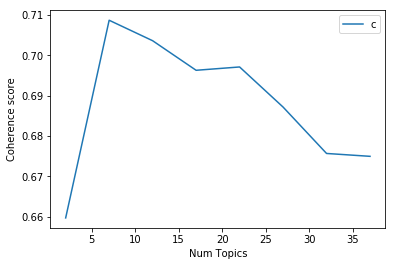

In [105]:
# Show graph
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, c_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_values"), loc='best')
plt.show()

In [106]:
# Print the coherence scores
for m, cv in zip(x, c_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6598
Num Topics = 7  has Coherence Value of 0.7086
Num Topics = 12  has Coherence Value of 0.7036
Num Topics = 17  has Coherence Value of 0.6963
Num Topics = 22  has Coherence Value of 0.6971
Num Topics = 27  has Coherence Value of 0.6872
Num Topics = 32  has Coherence Value of 0.6757
Num Topics = 37  has Coherence Value of 0.675


In [110]:
# Select the model and print the topics
best_model = models_list[1]
model_topics = best_model.show_topics(formatted=False)
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.034*"night" + 0.025*"customer" + 0.025*"money" + 0.023*"check" + '
  '0.017*"work" + 0.013*"deal" + 0.013*"day" + 0.013*"morning" + 0.012*"care" '
  '+ 0.012*"guest"'),
 (1,
  '0.059*"line" + 0.032*"drink" + 0.031*"night" + 0.027*"club" + 0.024*"show" '
  '+ 0.023*"friend" + 0.022*"party" + 0.018*"group" + 0.016*"airport" + '
  '0.016*"music"'),
 (2,
  '0.158*"food" + 0.080*"buffet" + 0.037*"dinner" + 0.037*"dessert" + '
  '0.034*"breakfast" + 0.028*"lunch" + 0.026*"price" + 0.018*"plate" + '
  '0.016*"seafood" + 0.016*"item"'),
 (3,
  '0.070*"burger" + 0.062*"food" + 0.051*"restaurant" + 0.037*"server" + '
  '0.034*"menu" + 0.031*"steak" + 0.029*"fry" + 0.020*"waiter" + 0.017*"beer" '
  '+ 0.014*"appetizer"'),
 (4,
  '0.103*"vegas" + 0.058*"strip" + 0.035*"restaurant" + 0.033*"price" + '
  '0.027*"water" + 0.023*"casino" + 0.021*"trip" + 0.020*"bellagio" + '
  '0.019*"coffee" + 0.015*"visit"'),
 (5,
  '0.173*"room" + 0.115*"hotel" + 0.038*"pool" + 0.026*"casino" + 0.024*"vie

In [111]:
# Showing the most dominant topic in each review - is essentially categorizing each review into a topic created by the topic model
# Modified function from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_dom_topics_(ldamodel=lda_model, corpus=corpus, texts=data):
    #Create Dataframe
    sentence_topics_df = pd.DataFrame()
    
    # Main topic in each review
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the dom topic, % contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                # Get the representation for a single topic; word_prop = word proportion
                word_prop = ldamodel.show_topic(topic_num)
                keywords_for_topic = ", ".join([word for word, proportion in word_prop])
                sentence_topics_df =  sentence_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), keywords_for_topic]), ignore_index=True)
            else:
                break
    sentence_topics_df.columns = ['Dominant Topic', '% Contribution', 'Topic Keywords']

    contents = pd.Series(texts)
    sentence_topics_df = pd.concat([sentence_topics_df, contents], axis=1)
    return(sentence_topics_df)


In [118]:
df_topic_sents_keywords = format_dom_topics_(ldamodel=best_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Review #', 'Dominant Topic', 'Topic % Contrib', 'Keywords', 'Text']


In [120]:
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(10)

,Review_No,Dominant Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1846,"vegas, strip, restaurant, price, water, casino, trip, bellagio, coffee, visit","Wow, we LOVED this place! We went on a Sunday afternoon for brunch. Service was prompt, we didn't have a wait at all. I loved the decor, all whites and beige. The interior of the restaurant opens directly onto the large patio so we got lots of fresh air and sunlight which was fabulous. Our waitress was attentive and quick. My friend who is a salad snob said her ""Simple Salad"" was one of the best she has ever had. I got the protein omelette which was very tasty. Our other friend ordered the sticky bun which was massive. Definitely will put you in a sugar coma if you try to eat the whole thing. The bowl of fruit was huge (definitely not the little side dish you typically think of) and has a great variety of fruits to snack on. Definitely one of my favorite restaurants on the strip."
1,1,6.0,0.2719,"chicken, pizza, flavor, sandwich, sauce, cheese, meat, portion, bread, dish","Let's start with dessert... Four diners chose four desserts.... Figs n Berries with Thyme ice cream , Creme BrÃ»lÃ©e , lemon tart with pinion crust, and something with chocolate sauce!!! No fault with this sweet array of perfection! Was surprised waiter made no after dinner beverage recommendations. Waiter was friendly and staff attentive! Refills were abundant, first rate attention to every detail! While the choice of swordfish was mine... It was the trout that stole the show where fish was concerned! It's so delightful to dine with foodies who live to share bites! Chicken was succulent also putting my dry swordfish to shame. It was a shame I didn't eat more of the laurel bread n butter... Sweet cream butter... Laid out directly on the tablecloth...interesting... And why Not???now let's talk Lamb! Moist, tender rich in flavor...four nice medallions made mouths water. The contents of that plate evaporated swiftly! Sooo yummy! Beer list is nice, waitstaff is knowledgeable on pairings and speak confidently as to menu items ingredients and methods of preparations. Inquires re: diners allergies raise awareness that the kitchen staff is able to help avoid even inadvertent cross allergen exposure! Bravo/ Brava!"
2,2,2.0,0.1709,"food, buffet, dinner, dessert, breakfast, lunch, price, plate, seafood, item","If you've been to a nice churrascaria before then you won't be very impressed by this place. Make sure you're on time for your reservation. If you're a little late, you'll wait in line with everyone else-our fault. Make sure you know what u want because you may not see your waiter for awhile, but the meat servers did pretty well making their rounds. The food was decent. I used a groupon so it worked out but if I had to pay full price, id go somewhere else."
3,3,6.0,0.1844,"chicken, pizza, flavor, sandwich, sauce, cheese, meat, portion, bread, dish","Amazing doesn't even begin to describe this pizza!!! A group of 8 of us were hanging at the chandelier and got hungry so one of the men trekked to find us some sustenance. The sausage and pepperoni was incredible, I wish I had taken a picture to put up here. Just be sure, it's kinda pricey (it's Vegas, hello) but delicious nonetheless"
4,4,1.0,0.1898,"line, drink, night, club, show, friend, party, group, airport, music","This was a ehhh buffet in my opinion. Well overpriced, quality was ok, service was good...line was super long, 2 hour wait or pay $20 for a ""front of the line pass"" . Maybe worth it's for one or two people but when you take four or more that really adds up. So ninethe nonetheless we skipped that option and waited. About a hour in waiting they finally had someone go around the line offering water to the waiting ""poor"" folks who cant afford or wont give up the extra fee for ""front of line pass"". 2 hours later we're in and ready to grub. Now for the price per person I was expecting superior quality food and selection but did not live up to the 

In [119]:
# topic distribition across documents
topic_counts = df_topic_sents_keywords['Dominant Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution



3.0    0.1896
5.0    0.1830
6.0    0.1793
2.0    0.1791
1.0    0.1007
0.0    0.0849
4.0    0.0834
Name: Dominant Topic, dtype: float64